In [97]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import Word
import re

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# We will focus our efforts on making a model to classify the 500 other reviews that are unlabeled.

In [33]:
df = pd.read_csv('Seven_Sins_Restobar.tsv', delimiter = '\t', quoting = 3, encoding = 'unicode_escape')

In [34]:
df.head(10)

Review  Liked
0  "I also had to taste my Mom's multi-grain pump...      1
1          "I'd rather eat airline food, seriously."      0
2      Cant say enough good things about this place.      1
3                       The ambiance was incredible.      1
4          The waitress and manager are so friendly.      1
5                  I would not recommend this place.      0
6         Overall I wasn't very impressed with Noca.      0
7                My gyro was basically lettuce only.      0
8                                  Terrible service!      0
9                           Thoroughly disappointed!      0

## We see that there are 2 columns, one that has the review and the other has the Liked or not as binary

## We have 2 ideas:
## 1 Is to look for the sentiment of the reviews and analyze the words on the negative ones, in order to see a pattern, if we analyze that we can get insights to improve our business

## 2 is to make a predictive model with the data that we have in order to recognize how the reviews will go (pos or neg)

# 1

## We will analyze the sentiment of the reviews on another column, being the first number the Polarity and the second being the subjectivity

In [16]:
dfr = df['Review']

In [35]:
df['sentiment'] = df['Review'].apply(lambda tweet: TextBlob(tweet).sentiment)

In [50]:
df.head()

Review  Liked  polarity  \
0  "I also had to taste my Mom's multi-grain pump...      1  0.466667   
1          "I'd rather eat airline food, seriously."      0 -0.333333   
2      Cant say enough good things about this place.      1  0.350000   
3                       The ambiance was incredible.      1  0.900000   
4          The waitress and manager are so friendly.      1  0.375000   

   subjectivity  
0      0.766667  
1      0.666667  
2      0.550000  
3      0.900000  
4      0.500000

In [37]:
sentiment_series = df['sentiment'].tolist()

columns = ['polarity', 'subjectivity']

dfs = pd.DataFrame(sentiment_series, columns=columns, index=df.index)

In [40]:
dfs.head()

polarity  subjectivity
0  0.466667      0.766667
1 -0.333333      0.666667
2  0.350000      0.550000
3  0.900000      0.900000
4  0.375000      0.500000

In [41]:
df['polarity'] = dfs['polarity']

In [42]:
df['subjectivity'] = dfs['subjectivity']

In [44]:
df = df.drop("sentiment", axis=1)

## We analyzed the sentiment of the reviews, and added in 2 new columns for the DF

In [114]:
df.tail(15)

Review  Liked  polarity  \
485  Seafood was limited to boiled shrimp and crab ...      0  0.076190   
486            The selection of food was not the best.      0  1.000000   
487           Delicious and I will absolutely be back!      1  0.500000   
488  "This isn't a small family bar, this is a fine...      1  0.083333   
489  They had a toro tartare with a cavier that was...      1  0.133333   
490  I dont think I will be back for a very long time.      0 -0.032500   
491  "It was attached to a gas station, and that is...      0  0.700000   
492                               How awesome is that.      1  1.000000   
493                    I will be back many times soon.      1  0.250000   
494  The menu had so much good stuff on it i could ...      1  0.875000   
495  "Worse of all, he humiliated his worker right ...      0 -0.371429   
496                    CONCLUSION: Very filling meals.      1  0.200000   
497  Their daily specials are always a hit with my ...      1  0.000000   
498  The pancake was also really good and pretty la...      1  0.388095   
499  "This was my first crawfish experience, and it...      1  0.625000   

     subjectivity  
485      0.380952  
486      0.300000  
487      0.500000  
488      0.450000  
489      0.662500  
490      0.260000  
491      0.600000  
492      1.000000  
493      0.250000  
494      0.600000  
495      0.711905  
496      0.300000  
497      0.000000  
498      0.676190  
499      0.666667

In [47]:
df[df['polarity']==0]

Review  Liked  polarity  \
5                    I would not recommend this place.      0       0.0   
7                  My gyro was basically lettuce only.      0       0.0   
16                        it was a drive to get there.      0       0.0   
18      "Anyway, I do not think i will go back there."      0       0.0   
20      "Oh this is such a thing of beauty, this bar."      1       0.0   
..                                                 ...    ...       ...   
454                                Food was so gooodd.      1       0.0   
456                                 I was so insulted.      0       0.0   
469  I don't think I'll be running back to Carly's ...      0       0.0   
483  We asked for the bill to leave without eating ...      0       0.0   
497  Their daily specials are always a hit with my ...      1       0.0   

     subjectivity  
5             0.0  
7             1.0  
16            0.0  
18            0.0  
20            0.5  
..            ...  
454           0.0  
456           0.0  
469           0.0  
483           0.0  
497           0.0  

[116 rows x 4 columns]

### It didn't give us good results, some obvious sentences got polarity value of 0.
### Also there is more than 20% of the reviews with 0 polarity, so we can't ignore them.
### We see some examples like "I would not recommend this place." that got 0 and 0
### This method can be used, but it won't have high accuracy, we will investigate further.

## We will investigate why there are columns with polarity 0, maybe there are words that are messing with the sentiment analysis, and after that we will analyze the ones with polarity different than 0

In [119]:
df0 = df[df['polarity']==0]
df0

Review  Liked  polarity  \
5                    I would not recommend this place.      0       0.0   
7                  My gyro was basically lettuce only.      0       0.0   
16                        it was a drive to get there.      0       0.0   
18      "Anyway, I do not think i will go back there."      0       0.0   
20      "Oh this is such a thing of beauty, this bar."      1       0.0   
..                                                 ...    ...       ...   
454                                Food was so gooodd.      1       0.0   
456                                 I was so insulted.      0       0.0   
469  I don't think I'll be running back to Carly's ...      0       0.0   
483  We asked for the bill to leave without eating ...      0       0.0   
497  Their daily specials are always a hit with my ...      1       0.0   

     subjectivity  
5             0.0  
7             1.0  
16            0.0  
18            0.0  
20            0.5  
..            ...  
454           0.0  
456           0.0  
469           0.0  
483           0.0  
497           0.0  

[116 rows x 4 columns]

In [124]:
dfnew['Review'] = df0['Review']


In [129]:
dfstring = dfnew.to_string(index=False)

In [ ]:
dfstring = dfstring.replace('\n',' ')

In [135]:
stringed = re.sub('[^a-zA-Z]', ' ', dfstring)

In [140]:
soup = BeautifulSoup(stringed) 
text = soup.get_text(strip=True)

In [143]:
tokens = [t for t in text.split()]
 

In [144]:
freq = nltk.FreqDist(tokens)
 
for key,val in freq.items():
 
    print (str(key) + ':' + str(val))

Review:1
I:60
would:6
not:16
recommend:4
this:16
place:10
My:1
gyro:1
was:11
basically:1
lettuce:1
only:1
it:10
a:22
drive:1
to:21
get:2
there:6
Anyway:1
do:1
think:5
i:2
will:8
go:9
back:16
Oh:1
is:11
such:1
thing:2
of:7
beauty:1
bar:2
If:3
you:5
haven:1
t:14
gone:1
here:11
GO:1
NOW:1
This:3
two:3
thumbs:1
up:3
way:2
were:3
zero:2
stars:4
give:1
We:7
waited:4
for:10
thirty:1
minutes:3
be:15
seated:2
alt:1
No:1
m:6
going:4
eat:4
the:16
potato:1
that:3
found:1
saving:1
room:1
guess:1
maybe:1
we:2
went:1
on:5
an:2
off:1
night:1
but:3
w:1
AVOID:1
THIS:1
ESTABLISHMENT:1
heart:1
never:3
and:16
ne:1
consider:1
theft:1
Waited:1
Over:1
rated:2
Their:4
steaks:1
are:6
recommended:1
After:3
pulled:1
my:5
car:1
another:1
All:1
in:6
all:5
can:5
assure:1
ll:4
OMG:1
felt:2
like:4
had:6
eaten:1
pizza:1
food:5
u:1
The:3
croutons:1
also:4
taste:1
homemade:1
which:1
e:1
got:3
home:1
see:1
driest:1
damn:1
wings:1
ever:2
It:4
regular:1
stop:1
trips:1
Phoenix:1
miss:1
wish:1
they:2
one:3
Philadelphia:1
just

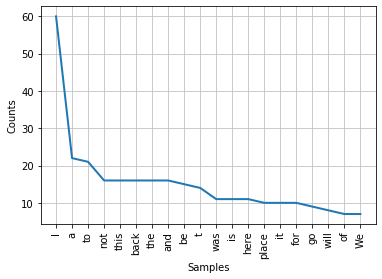

In [145]:
freq.plot(20, cumulative=False)

## We see that these words are the ones that make our sentiment analysis get 0 polarity, we can get rid of some of them in order to run again the analysis and check if polarity improves, but we will focus now on studying the words that make people Like or Dislike the place

In [152]:
dfnl1 = pd.DataFrame()
dfnl = df[df['Liked']==0]
dfnl1['Review'] = dfnl['Review']
dfstring2 = dfnl1.to_string(index=False)
dfstring2 = dfstring2.replace('\n',' ')
stringed2 = re.sub('[^a-zA-Z]', ' ', dfstring2)
soup2 = BeautifulSoup(stringed2) 
text2 = soup2.get_text(strip=True)
tokens2 = [t for t in text2.split()]
freq = nltk.FreqDist(tokens2)
 
for key,val in freq.items():
 
    print (str(key) + ':' + str(val))

Review:1
I:96
d:3
rather:2
eat:5
airline:1
food:20
seriously:3
would:7
not:39
recommend:3
this:15
place:16
Overall:1
wasn:3
t:23
very:9
impressed:4
with:9
Noca:1
My:7
gyro:1
was:60
basically:1
lettuce:1
only:2
Terrible:2
service:12
Thoroughly:1
disappointed:2
it:13
a:45
drive:2
to:38
get:3
there:9
Anyway:1
do:4
think:6
i:5
will:11
go:11
back:19
A:3
greasy:1
unhealthy:1
meal:3
first:1
time:4
and:40
might:1
just:4
be:22
the:61
last:2
Similarly:1
delivery:1
man:1
did:5
say:5
wor:1
And:2
way:4
expensive:1
management:1
If:4
were:5
zero:2
stars:3
give:2
Worst:3
martini:1
ever:6
We:12
waited:4
for:17
thirty:1
minutes:3
seated:2
alt:1
won:8
try:2
going:6
even:3
if:4
s:10
empty:1
No:3
m:10
potato:1
that:9
found:3
hello:1
we:9
right:2
you:8
The:38
desserts:1
bit:3
strange:1
guess:1
maybe:1
went:3
on:5
an:3
off:2
night:1
but:12
w:2
However:2
my:8
recent:1
experience:2
at:13
particu:1
know:1
is:19
like:5
other:1
bars:2
all:5
AVOID:1
THIS:1
ESTABLISHMENT:1
bar:1
suffers:1
from:7
trying:1
hard:2
sal

In [153]:
freq.plot(20, cumulative=False)

## Now we analyze the ones that liked the place

In [154]:
dfl1 = pd.DataFrame()
dfl = df[df['Liked']==1]
dfl1['Review'] = dfl['Review']
dfstring3 = dfl1.to_string(index=False)
dfstring3 = dfstring3.replace('\n',' ')
stringed3 = re.sub('[^a-zA-Z]', ' ', dfstring3)
soup3 = BeautifulSoup(stringed3) 
text3 = soup3.get_text(strip=True)
tokens3 = [t for t in text3.split()]
freq = nltk.FreqDist(tokens3)
 
for key,val in freq.items():
 
    print (str(key) + ':' + str(val))

Review:1
I:61
also:12
had:17
to:28
taste:3
my:15
Mom:1
s:7
multi:1
grain:1
pump:1
Cant:1
say:5
enough:3
good:28
things:1
about:4
this:16
place:20
The:55
ambiance:2
was:59
incredible:1
waitress:2
and:75
manager:2
are:15
so:8
friendly:9
don:2
t:11
each:1
much:2
pasta:1
but:3
love:8
the:60
homem:1
Give:1
it:16
a:43
try:1
you:13
will:5
be:8
happy:4
did:2
By:1
far:1
BEST:1
cheesecurds:1
we:7
have:9
ever:3
Reasonably:1
priced:1
Everything:2
perfect:4
night:3
were:19
in:21
food:21
is:35
very:13
for:15
your:5
typical:1
bar:12
At:1
first:7
glance:1
lovely:2
bakery:1
cafe:1
Point:1
finger:1
at:5
any:1
item:1
on:12
menu:4
or:3
Oh:1
such:2
thing:2
of:13
beauty:1
If:3
haven:1
gone:1
here:11
GO:1
NOW:1
Those:1
burgers:1
amazing:9
Be:1
sure:1
order:2
dessert:1
even:6
if:2
need:1
This:13
time:9
can:5
wait:2
until:1
bartender:1
nice:11
tasty:2
two:1
thumbs:1
up:3
way:2
best:2
Vegas:5
breakfast:3
just:5
c:1
authentic:2
Mexican:1
want:4
An:3
excellent:3
new:3
by:3
an:5
experienced:1
Frenchman:1
Great:9
s

In [155]:
freq.plot(20, cumulative=False)

## We didn't get much information out of this, the food could be a factor but it's in both type of reviews , so it's not a major issue.

## We can improve the sentiment analysis by removing some words that make polarity go to 0 , then we could make a model out of sentiment analysis without actually knowing the result of the review, so that could be a way to solve the other 500 reviews problem.
## We will move on to the next idea

## We will clean the Reviews and do models using those to go with our second idea

In [53]:
df2 = df #We make a backup in case we do a major fail

In [99]:


corpus = [] 

for i in range(0, 500):
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i]) #Removes all but letters (and Capitals)
    review = review.lower() #Put all the letters in lowercase
    review = review.split() #Creates a list of different words
    ps = PorterStemmer() #We use Stemming for taking the root of words
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review) #For reversing the process (list -> string)
    corpus.append(review) #Generate a list of one string per observation

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [108]:
def accuracy(matrix):
    return((matrix[0,0]+matrix[1,1])/(matrix[0,0]+matrix[1,1]+matrix[0,1]+matrix[1,0]))

In [101]:
from sklearn.feature_extraction.text import CountVectorizer #Class that allows tokenization

cv = CountVectorizer(max_features = 1000) #Keepong the 1000 more frequent words

X = cv.fit_transform(corpus).toarray() #Creation of the Sparsematrix

y = df.iloc[:, 1].values #Defining our response variable

## The idea here, is to predict the results of the reviews using different models and compare them

## We will run 5 models and compare results.

In [109]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Fitting Naive Bayes to the Training set

nb = GaussianNB()
nb.fit(X_train, y_train)

# fit a Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train)

#fit a DT
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

#fit a K Neighbors
kne = KNeighborsClassifier()
kne.fit(X_train, y_train)

#fit a Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)


# Predicting the Test set results
nb_y_pred  =  nb.predict(X_test)
lr_y_pred  =  lr.predict(X_test)
DT_y_pred  =  DT.predict(X_test)
kne_y_pred =  kne.predict(X_test)
lda_y_pred = lda.predict(X_test)

# Making the Confusion Matrix
nb_cm = confusion_matrix(y_test, nb_y_pred)
print('Gaussian NB:')
print('Accuracy: ',accuracy(confusion_matrix(y_test,nb_y_pred )))
print(nb_cm)

lr_cm = confusion_matrix(y_test, lr_y_pred)
print('Log Reg:')
print('Accuracy: ',accuracy(confusion_matrix(y_test,lr_y_pred )))
print(lr_cm)

kne_cm = confusion_matrix(y_test, kne_y_pred)
print('K Neighbors:')
print('Accuracy: ',accuracy(confusion_matrix(y_test,kne_y_pred )))
print(kne_cm)

dt_cm = confusion_matrix(y_test, DT_y_pred)
print('Decision Tree:')
print('Accuracy: ',accuracy(confusion_matrix(y_test,DT_y_pred )))
print(dt_cm)

lda_cm = confusion_matrix(y_test, lda_y_pred)
print('Linear Discriminant Analysis:')
print('Accuracy: ',accuracy(confusion_matrix(y_test,lda_y_pred )))
print(lda_cm)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Gaussian NB:
Accuracy:  0.71
[[27 23]
 [ 6 44]]
Log Reg:
Accuracy:  0.7
[[35 15]
 [15 35]]
K Neighbors:
Accuracy:  0.63
[[40 10]
 [27 23]]
Decision Tree:
Accuracy:  0.72
[[35 15]
 [13 37]]
Linear Discriminant Analysis:
Accuracy:  0.66
[[35 15]
 [19 31]]


Naive Bayes: ROC AUC=0.710
Logistic: ROC AUC=0.768
K Neigh: ROC AUC=0.670
LDA: ROC AUC=0.642
Dec Tree: ROC AUC=0.720


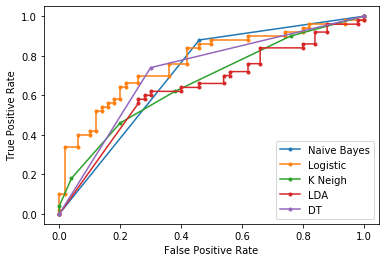

In [112]:
# predict probabilities
nb_probs = nb.predict_proba(X_test)
lr_probs = lr.predict_proba(X_test)
kne_probs = kne.predict_proba(X_test)
lda_probs = lda.predict_proba(X_test)
dt_probs = DT.predict_proba(X_test)
#svc_probs = svc.predict_proba(X_test)

# keep probabilities for the positive outcome only
nb_probs  = nb_probs[:, 1]
lr_probs  = lr_probs[:, 1]
kne_probs = kne_probs[:, 1]
lda_probs = lda_probs[:, 1]
dt_probs  = dt_probs[:, 1]
#svc_probs  = svc_probs[:, 1]

# calculate scores
nb_auc = roc_auc_score(y_test, nb_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
kne_auc = roc_auc_score(y_test, kne_probs)
lda_auc = roc_auc_score(y_test, lda_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
#svc_auc = roc_auc_score(Y_test, svc_probs)

# summarize scores
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('K Neigh: ROC AUC=%.3f' % (kne_auc))
print('LDA: ROC AUC=%.3f' % (lda_auc))
print('Dec Tree: ROC AUC=%.3f' % (dt_auc))
#print('SVC: ROC AUC=%.3f' % (dt_auc))

# calculate roc curves
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
kne_fpr, kne_tpr, _ = roc_curve(y_test, kne_probs)
lda_fpr, lda_tpr, _ = roc_curve(y_test, lda_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
#svc_fpr, svc_tpr, _ = roc_curve(Y_test, svc_probs)

# plot the roc curve for the model
pyplot.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
pyplot.plot(kne_fpr, kne_tpr, marker='.', label='K Neigh')
pyplot.plot(lda_fpr, lda_tpr, marker='.', label='LDA')
pyplot.plot(dt_fpr, dt_tpr, marker='.', label='DT')
#pyplot.plot(svc_fpr, svc_tpr, marker='.', label='SVC')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

### Even though that all the models have better accuracy, we can see that the K Neighbors model has less false positives, that is an important thing to care about, because for the business is better to get that number as low as possible. It still has a low accuracy and AUC , but can be considered, if not we would go for the DT or LR models as well.


## Now we can classify the other 500 reviews with our new model.
## A suggestion to the owner is to decide if he needs a more accurate model, or if what he needs is a model that gets the lowest false positives as possible, because with that he can take action using the reviews to know what to improve in his business